In [2]:
from typing import Tuple, List
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import joblib

try:
    import Orange
    orange_imported = True
except ModuleNotFoundError:
    print("orange3 not available")
    orange_imported = False

# Global settings
sns.set_style('ticks')
memory = joblib.Memory("data/cache", verbose = 0)

orange3 not available


## Overview

This file aims to analyze results and create figures for the Experiments.
The class **RunLog** collects logs for a single **Problem** across search strategies:

**Problems**: svm, xgboost, rpart, glmnet, knn, rf.
**Search Strategies**: 
- mupluslambda: EA described in the paper
- random_search: Random Search on the Grammar employed for the EA. Used as a baseline
- True (constants_only): EA, but only constant, non-symbolic terminals

Each RunLog contains several replications of each search strategy on each task, identifyable by the 'run' column.


####  Expected file structure.
The working directory of the notebook server should contain:
 - `figures/`
 - `/run/results2/` in which all the `{problem}_{search}` folders are contained

In [24]:
class Runlog:
    """
    Read logs for a given problem across several searches
    """
    def __init__(self, problem: str, searches: List, logdir: str):
        self.problem = problem
        self.searches = searches
        self.logdir = logdir
    
    @property
    def data(self):
        df = pd.DataFrame([])
        for search in self.searches:
            df = df.append(read_run_logs(problem=self.problem, search=search, target="evaluations", dir=self.logdir))
        return df
    
    @property
    def trace_data(self):
        df = pd.DataFrame([])
        for search in self.searches:
            df = df.append(read_trace_logs(problem=self.problem, search=search, dir=self.logdir))
        return df
    
    def pick_final_expression(self, method = "best", **kwargs):
        """
        Pick final expression on "in" data
        :method: either "relative", "shortest" or "best"
        """
        df = self.data.copy()
        df = df[df['expression'].str.contains(',')]
        df = get_final_paretofront(df)
        df = df.pivot_table(index=["run", "task", "gen", "length", "problem", "search", "expression"], columns="inout", values="score")
        df = df.reset_index()
        if method == "shortest":
            out = df[df.groupby(['run', 'search'])['length'].transform(min) == df['length']]
        elif method == "relative":
            out = df.loc[[pick_relative(group, **kwargs) for name, group in df.groupby(['run', 'search'])]]
        else:
            out = df[df.groupby(['run', 'search'])['in'].transform(max) == df['in']]
        return out
    
    def get_benchmark_performances(self):
        """
        Load benchmark performances
        """
        df = self.data[~self.data['expression'].str.contains(',')]
        df = df.pivot_table(index=["run", "task","problem", "search", "expression"], columns="inout", values="score")
        df = df.reset_index()
        df = df[["task", "problem", "expression", "in", "out"]]
        df.drop_duplicates(inplace=True)
        return(df)


def pick_relative(x, eps=0.01, max_steps=1):
    """
    Pick by relative improvement; 
    Consider only at most `max_steps` longer, if better by 'eps', break if not
    """
    x = x.copy()
    if len(x) == 1:
        return(x.index.values[0])
    
    use_ix, length, score = None, 0, 0
    for ix, rw in x.iterrows():
        if rw['length'] - length > max_steps:
            break  # candidates are too big
        if rw['in'] - score < eps:
            continue  # not enough increase
        use_ix, length, score = ix, rw['length'], rw['in']        
    return use_ix

@memory.cache()
def read_run_logs(problem:str, search: str, target: str, dir: str):
    """
    Read all log-files for a given problem x search combination
    """
    log_dir = f"{dir}/{problem}_{search}/"
    if os.path.isdir(log_dir):
        dirs = [os.path.join(log_dir, f) for f in os.listdir(log_dir)]
        df = pd.DataFrame([])
        for dir in dirs:
            file = f"{dir}/{target}.csv"
            if os.path.isfile(file):
                tmpdf = pd.read_csv(file, sep=";")
                tmpdf['search'] = search
                # Pivot random search, rename constants only
                if search == "random_search":
                    tmpdf['search'] = tmpdf.apply(lambda x: x['search']+'_'+str((x['gen'] + 1)*100), axis=1)  
                    tmpdf['endresult'] = True
                elif search == "True":
                    tmpdf['search'] = "constants_only"
                df = df.append(tmpdf)
        # Rename and add problem
        if problem == "rf": 
            df['problem'] = "random forest"
        else: 
            df['problem'] = problem
        return df
    else:
        print(log_dir,'is not path')

def get_final_paretofront(df: pd.DataFrame):
    """
    Filter pareto front
    """
    return df[df.endresult]
    
def read_trace_logs(problem:str, search: str, dir: str):
    """
    Read "progress" log-files for a given problem x search combination (Optimization Traces)
    """
    log_dir = f"{dir}/{problem}_{search}/"
    if os.path.isdir(log_dir):
        dirs = [os.path.join(log_dir, f) for f in os.listdir(log_dir)]
        df = pd.DataFrame([])
        for dir in dirs:
            file = f"{dir}/progress.csv"
            if os.path.isfile(file):
                tmpdf = pd.read_csv(file, sep=";")
                tmpdf['search'] = search
                if search == "True":
                    tmpdf['search'] = "constants_only"
                elif search == "random_search":
                    tmpdf['generation'] = (tmpdf['generation'] + 1)*100
                df = df.append(tmpdf)

        # Rename and add problem
        if problem == "rf": 
            df['problem'] = "random forest"
        else: 
            df['problem'] = problem
        return df


### Log Collection:
**log** is a dict of all logs in the **logdir**(here `/runs/results2`) folder. 

Most of the time we are only interested in a single individual from the pareto-front per log.
We can obtain this via `pick_final_expression(<strategy>)` from each log.

In [29]:
# Collect logs for all problems
problems = ['svm', 'glmnet', 'rf', 'rpart', 'knn']
search_strategies = ["mupluslambda", "random_search", "True"]
log = {}
for problem in problems:
    log[problem] = Runlog(problem, search_strategies, logdir="runs/results2")

In [30]:
# Get final expression acording to some pick strategy data. 
# Columns 'in' and 'out' refer to in- and out-of-sample performance
df = pd.DataFrame([])

for k in log.keys():
    pdf = log[k].pick_final_expression("relative")
    pdf['problem'] = k
    df = df.append(pdf)
df[['task', 'length', 'problem', 'search', 'expression', 'in', 'out']].head()

inout,task,length,problem,search,expression,in,out
0,23,1,svm,constants_only,"make_tuple(1073, 0.0010463920660818081)",0.8616,0.9158
1,53,1,svm,constants_only,"make_tuple(180, 0.002485554605757483)",0.8604,0.9240
4,9957,2,svm,mupluslambda,"make_tuple(m, truediv(mkd, xvar))",0.9012,0.9644
9,31,1,svm,random_search_100,"make_tuple(p, mkd)",0.8902,0.9314
11,31,1,svm,random_search_200,"make_tuple(p, mkd)",0.8902,0.9314


### Experiment 1: Efficacy of EA algorithm: 
Boxplot of mu+lambda EA versus random search.
We only analyze performance on hold-out data, as this is what we are interested in
Open Question: Do we average before plotting?

### Performance
The following boxplot shows normalized accuracy across problems and search strategies

**1. Un-aggregated (across all replications):**

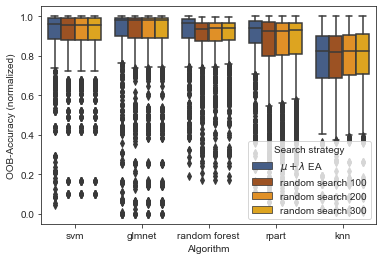

In [31]:
sns.set_palette([sns.xkcd_rgb[x] for x in ["denim blue", "burnt sienna", "tangerine", "yellow orange"]])
data = df[df.search != "constants_only"].copy()
data.replace("rf", "random forest", inplace=True)
p = sns.boxplot(data=data, x="problem", y="out", hue = "search")
p.set(ylabel='OOB-Accuracy (normalized)', xlabel='Algorithm')
p.legend(loc='lower right')
p.legend_.set_title("Search strategy")
new_labels = [r'$\mu + \lambda$ EA', 'random search 100', 'random search 200', 'random search 300']
for t, l in zip(p.legend_.texts, new_labels): t.set_text(l)
plt.show()

**2. Aggregated across replications:**

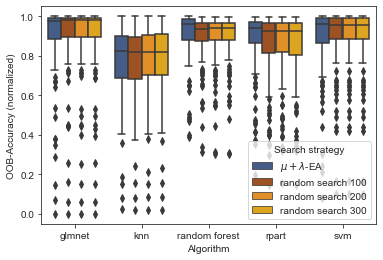

In [33]:
aggdf = data.groupby(["task", "search","problem"]).agg(np.mean).reset_index()
sns.set_palette([sns.xkcd_rgb[x] for x in ["denim blue", "burnt sienna", "tangerine", "yellow orange"]])
p = sns.boxplot(data=aggdf, x="problem", y="out", hue = "search")
p.set(ylabel='OOB-Accuracy (normalized)', xlabel='Algorithm')
p.legend(loc='lower right')
p.legend_.set_title("Search strategy")
new_labels = [r'$\mu + \lambda$-EA', 'random search 100', 'random search 200', 'random search 300']
for t, l in zip(p.legend_.texts, new_labels): t.set_text(l)
plt.savefig("figures/experiment_1.png", bbox_inches='tight', pad_inches=.1)
plt.show()

3. **Hypothesis Tests:**

In [36]:
if orange_imported:
    #I still have to figure out how to annotate those plots
    aggdf["out_rank"] = aggdf.groupby(["task", "problem"]).out.rank(ascending=False)
    aggdf2 = aggdf.groupby(["problem", "search"])["out_rank"].mean().reset_index()

    for problem in aggdf.problem.unique():
        data = aggdf2[aggdf2.problem == problem]
        names = data["search"].values
        avg_ranks = data["out_rank"].values
        cd = Orange.evaluation.compute_CD(avg_ranks, len(aggdf[aggdf.problem == problem]))
        Orange.evaluation.graph_ranks(avg_ranks, names, cd=cd, width=6, textspace=1.5)
        plt.show()
else:
    print("orange not available")

orange not available


### Efficiency
Here we investiage the average number of generations required to converge

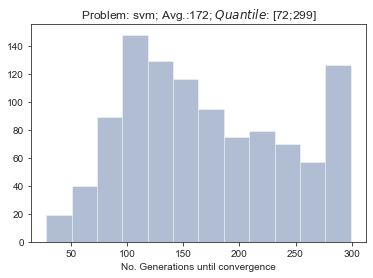

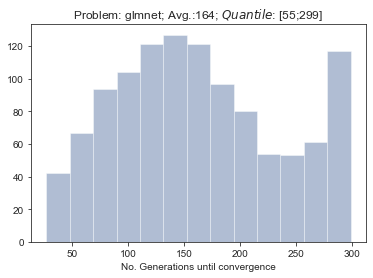

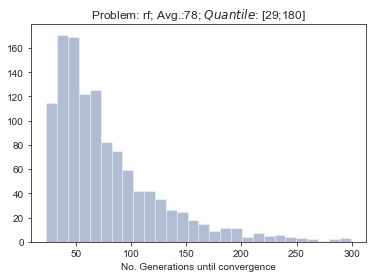

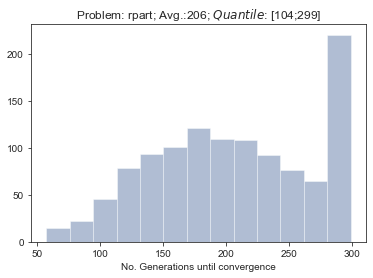

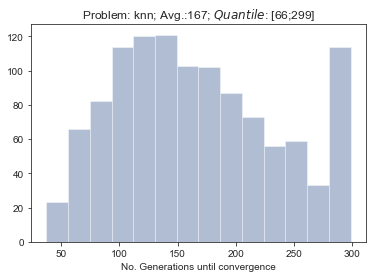

In [37]:
for problem in df.problem.unique():
    data = df[(df.search == "mupluslambda") & (df.problem == problem)]["gen"]
    p = sns.distplot(data, kde=False)
    p.set(xlabel='No. Generations until convergence')
    p.set_title(f'Problem: {problem}; Avg.:{round(data.mean()):.0f}; $Quantile$: [{data.quantile(.05):.0f};{data.quantile(.95):.0f}]')
    plt.show()

In [ ]:
#Get optimization traces
tdf = pd.DataFrame([])
for k in log.keys():
    tdf = tdf.append(log[k].trace_data)
tdf.head()

In [73]:
# Trace plots: random search (orange) vs mupluslambda (blue)
for problem in tdf.problem.unique():
    data = tdf[(tdf.search == "mupluslambda") & (tdf.problem == problem)]
    p = sns.lineplot(data=data, x="generation", y="score_max", hue="search", units="run", estimator=None)
    data = tdf[(tdf.search == "random_search") & (tdf.problem == problem)]
    p = sns.scatterplot(data=data, x="generation", y="score_max", color="orange")
    p.legend_.remove()
    p.set(xlabel='No. Generation', ylabel="In-sample Fitness")
    p.set_title(f'Problem: {problem}')
    plt.show()

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f9433833790> (for post_execute):


KeyboardInterrupt: 

### Conclusions
- mupluslambda is more efficient, finds better in-sample solutions
- small differences in out-of-sample solutions (perhaps slight overfitting)

## Experiment 2: Benchmarking symbolic defaults

### Experiment 2.1: Benchmarking symbolic defaults on surrogates

Compare results to:
- Implementation defaults
- Static defaults
- Optimistic Random Search

In [56]:
# Collect implementation default performances
cols = ["task", "problem", "search", "in", "out"]
baselines = pd.DataFrame([])
for k in log.keys():
    bdf = log[k].get_benchmark_performances().rename(columns={"expression":"search"})[cols]
    bdf['problem'] = k
    baselines = baselines.append(bdf)

baselines.head()

inout,task,problem,search,in,out
0,45,svm,mlr_default,0.9969,0.2011
1,45,svm,sklearn_default,0.9969,0.9785
2,45,svm,symbolic_best,0.9969,0.9918
3,58,svm,mlr_default,0.9336,0.0236
4,58,svm,sklearn_default,0.9336,0.9861


In [57]:
# Collect optimistic random search performances
cols = ["task", "problem", "search", "in", "out"]
rsdf =  pd.DataFrame([])
for problem in problems:
    file = f"data/mlr_{problem}_baselines.csv"
    if os.path.isfile(file):
        prsdf = pd.read_csv(f"data/mlr_{problem}_baselines.csv", index_col=0).transpose()
        prsdf['task'] = [int(float(x)) for x in prsdf.index.values]
        prsdf = prsdf.melt(id_vars='task').rename(columns={"search_type":"search", "value":"out"})
        prsdf['problem'] = problem
        prsdf['in'] = np.nan
        prsdf = prsdf[prsdf['search'] != 'oracle']
        rsdf = rsdf.append(prsdf[cols])

rsdf.head()

,task,problem,search,in,out
106,3,svm,rs_2,NaN,0.615487
107,6,svm,rs_2,NaN,0.599002
108,11,svm,rs_2,NaN,0.730493
109,12,svm,rs_2,NaN,0.566405
110,14,svm,rs_2,NaN,0.502232


In [58]:
cols = ["task", "problem", "search", "in", "out"]
srdf = df[cols].append(baselines).append(rsdf)

# Average out-of-sample performances
srdf.groupby(['problem', 'search']).mean()[["out"]]

inout                           out
problem search                     
glmnet  constants_only     0.957486
        mlr_default        0.935791
        mupluslambda       0.960140
        random_search_100  0.957402
        random_search_200  0.957365
        random_search_300  0.956974
        rs_128             0.987558
        rs_16              0.936044
        rs_2               0.567390
        rs_32              0.958021
        rs_4               0.765041
        rs_64              0.977110
        rs_8               0.887694
        sklearn_default    0.005362
rf      constants_only     0.940846
        mlr_default        0.895937
        mupluslambda       0.937771
        random_search_100  0.921319
        random_search_200  0.921816
        random_search_300  0.921341
rpart   constants_only     0.900172
        mlr_default        0.854374
        mupluslambda       0.911355
        random_search_100  0.898589
        random_search_200  0.901351
        random_search_300  0.901076
        rs_128             0.969110
        rs_16              0.899288
        rs_2               0.703429
        rs_32              0.927404
        rs_4               0.806193
        rs_64              0.948961
        rs_8               0.859881
svm     constants_only     0.911427
        mlr_default        0.311537
        mupluslambda       0.938239
        random_search_100  0.934740
        random_search_200  0.936369
        random_search_300  0.937037
        rs_128             0.978104
        rs_16              0.930583
        rs_2               0.677543
        rs_32              0.953903
        rs_4               0.798034
        rs_64              0.967202
        rs_8               0.884871
        sklearn_default    0.933270
        symbolic_best      0.935559

**Unaggregated Boxplots:**

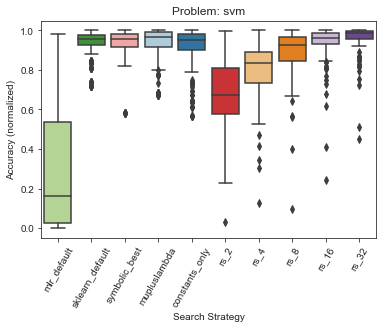

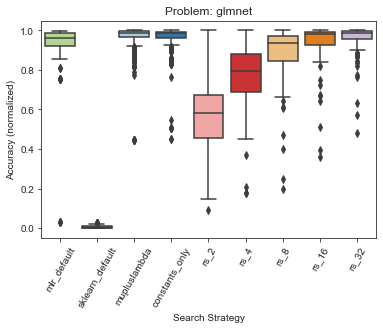

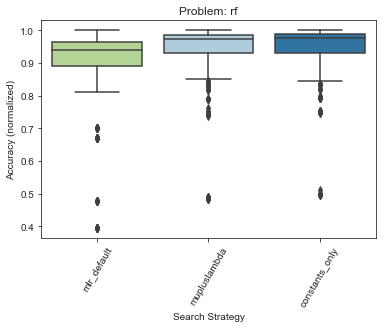

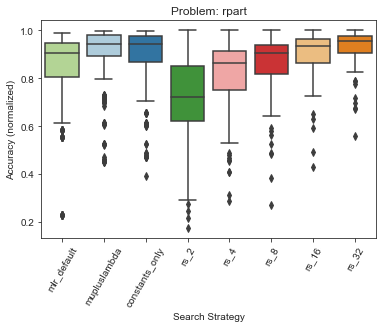

In [103]:
# This needs a lot of improvement: Fixed colors per algorithm ...
filter_search = ['random_search_100', 'random_search_200', 'random_search_300', 'rs_64', 'rs_128']
for problem in srdf.problem.unique():
    psrdf = srdf[~srdf.search.isin(filter_search)]
    psrdf = psrdf[psrdf["problem"] == problem]
    if len(psrdf):
        colors = sns.color_palette("Paired", psrdf.search.nunique())
        color_dict = dict(zip(psrdf.search.unique(), colors))
        order = ["mlr_default", "sklearn_default", "symbolic_best", "mupluslambda", "constants_only"]+["rs_"+str(x) for x in [2, 4, 8,16,32]]
        order = [x for x in order if x in psrdf.search.values]
        p = sns.boxplot(data=psrdf, x="search", y="out", palette = color_dict, order=order)
        p.set_xticklabels(p.get_xticklabels(), rotation=60)
        p.set(ylabel='Accuracy (normalized)', xlabel='Search Strategy')
        p.set_title(f'Problem: {problem}')
        plt.savefig(f"figures/boxplots_surrogates_{problem}.png", bbox_inches='tight', pad_inches=.1)
        plt.show()

**Aggregated across replications**

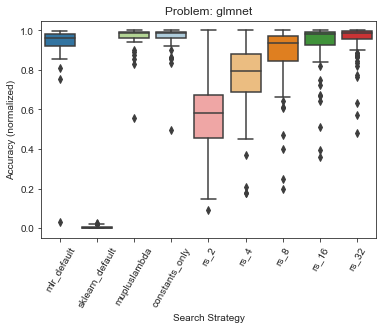

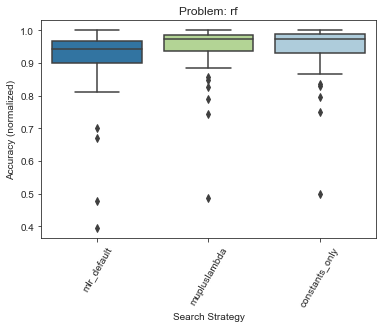

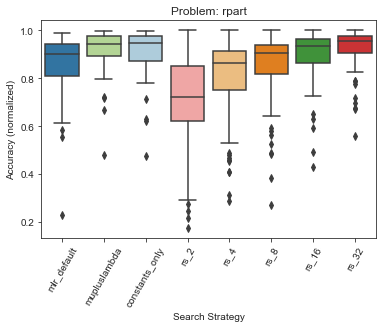

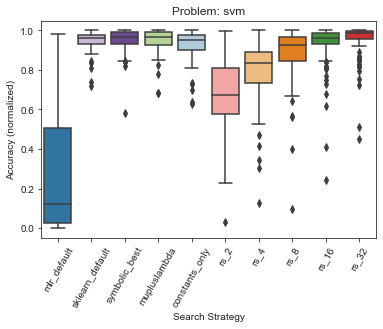

In [102]:
# This needs a lot of improvement: Fixed colors per algorithm ...
aggsrdf = srdf.groupby(['problem', 'search', "task"]).mean().reset_index()

for problem in aggsrdf.problem.unique():
    psrdf = aggsrdf[~aggsrdf.search.isin(filter_search)]
    psrdf = psrdf[psrdf["problem"] == problem]
    if len(psrdf):
        colors = sns.color_palette("Paired", psrdf.search.nunique())
        color_dict = dict(zip(psrdf.search.unique(), colors))
        order = ["mlr_default", "sklearn_default", "symbolic_best", "mupluslambda", "constants_only"]+["rs_"+str(x) for x in [2, 4, 8,16,32]]
        order = [x for x in order if x in psrdf.search.values]
        p = sns.boxplot(data=psrdf, x="search", y="out", palette = color_dict, order=order)
        p.set_xticklabels(p.get_xticklabels(), rotation=60)
        p.set(ylabel='Accuracy (normalized)', xlabel='Search Strategy')
        p.set_title(f'Problem: {problem}')
        plt.savefig(f"figures/boxplots_surrogates_agg_{problem}.png", bbox_inches='tight', pad_inches=.1)
        plt.show()

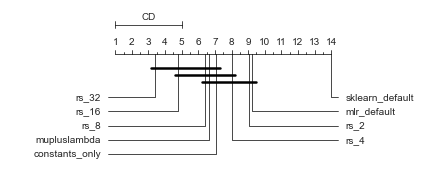

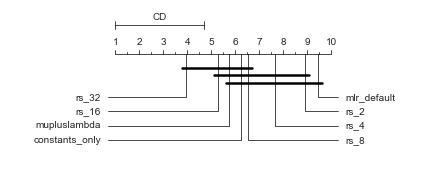

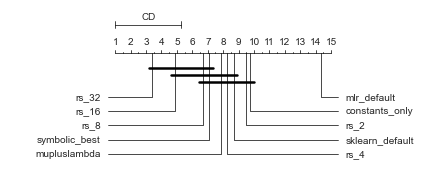

In [112]:
# Need to find out how to annotate those CD diagrams
aggsrdf["out_rank"] = aggsrdf.groupby(["task", "problem"]).out.rank(ascending=False)
aggdf2 = aggsrdf.groupby(["problem", "search"])["out_rank"].mean().reset_index()
aggdf2 = aggdf2[~aggdf2.search.isin(filter_search)]

for problem in aggdf.problem.unique():
    data = aggdf2[aggdf2.problem == problem]
    if len(data):
        names = data["search"].values
        avg_ranks = data["out_rank"].values
        cd = Orange.evaluation.compute_CD(avg_ranks, len(aggsrdf[aggsrdf.problem == problem]))
        Orange.evaluation.graph_ranks(avg_ranks, names, cd=cd, width=6, textspace=1.5, filename = f"figures/cd_surrogates_{problem}.png", bbox_inches='tight',)
        plt.show()

## Experiment 2.2: Benchmarking symbolic defaults on real data

Compare results to:
- Implementation defaults
- Static defaults

In [100]:
# Collect real data evaluations: Implementation defaults
cols = ["task", "problem", "search", "in", "out"]

real_baseline = pd.DataFrame([])
for problem in problems:
    file = f"data/mlr_{problem}_real_data_baselines_results.csv"
    if os.path.isfile(file):
        rbdf = pd.read_csv(file).rename(columns={"default":"search", "str":"expression", "problem_name": "problem", "mmce.test.mean":"out"})
        rbdf["in"] = np.nan
        rbdf["out"] = 1 - rbdf["out"] # Compute accuracy from mmce
        real_baseline = real_baseline.append(rbdf[cols])

real_baseline.sort_values(["problem", "task"]).head()

,task,problem,search,in,out
0,3,mlr_glmnet,sklearn_default,NaN,0.522216
114,3,mlr_glmnet,mlr_default,NaN,0.949621
1,6,mlr_glmnet,sklearn_default,NaN,0.040650
115,6,mlr_glmnet,mlr_default,NaN,0.612650
2,11,mlr_glmnet,sklearn_default,NaN,0.457578


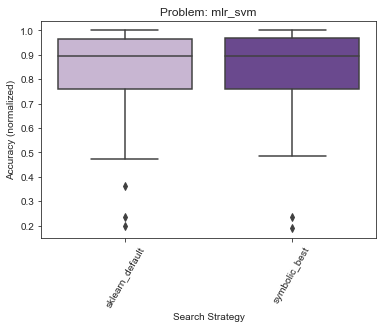

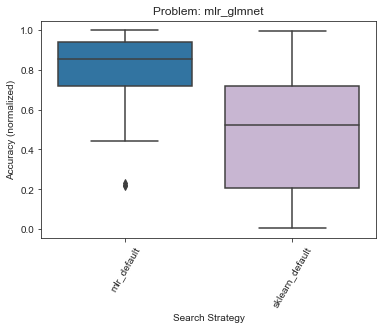

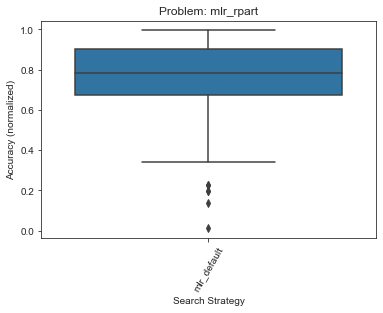

In [101]:
for problem in real_baseline.problem.unique():
    rbdf = real_baseline[real_baseline["problem"] == problem]
    if len(rbdf):
        colors = sns.color_palette("Paired", psrdf.search.nunique())
        color_dict = dict(zip(psrdf.search.unique(), colors))
        order = ["mlr_default", "sklearn_default", "symbolic_best", "mupluslambda", "constants_only"]+["rs_"+str(x) for x in [2, 4, 8,16,32]]
        order = [x for x in order if x in rbdf.search.values]
        p = sns.boxplot(data=rbdf, x="search", y="out", palette = color_dict, order=order)
        p.set_xticklabels(p.get_xticklabels(), rotation=60)
        p.set(ylabel='Accuracy (normalized)', xlabel='Search Strategy')
        p.set_title(f'Problem: {problem}')
        plt.savefig(f"figures/boxplots_realdata_{problem}.png", bbox_inches='tight', pad_inches=.1)
        plt.show()

In [ ]:
# Need to find out how to annotate those CD diagrams
real_baseline["out_rank"] = real_baseline.groupby(["task", "problem"]).out.rank(ascending=False)
agg_real_baseline = real_baseline.groupby(["problem", "search"])["out_rank"].mean().reset_index()


for problem in real_baseline.problem.unique():
    data = agg_real_baseline[agg_real_baseline.problem == problem]
    if len(data) > 1:
        names = data["search"].values
        avg_ranks = data["out_rank"].values
        cd = Orange.evaluation.compute_CD(avg_ranks, len(real_baseline[real_baseline["problem"] == problem]))
        Orange.evaluation.graph_ranks(avg_ranks, names, cd=cd, width=6, textspace=1.5, filename = f"figures/cd_realdata_{problem}.png", bbox_inches='tight',)
        plt.show()

# END OF WORKING ANALYSIS
Things below are previous / old analysis

### Strategies for picking final individual from the pareto front

In [210]:
cols = ["task", "problem", "search", "in", "out"]
big_df = pd.DataFrame()
for strat in ["best", "shortest", "relative"]:
    df = log.pick_final_expression(strat, eps=0.01, max_steps=2)[cols]
    bdf = log.get_benchmark_performances().rename(columns={"expression":"search"})[cols]
    df = df.append(bdf)
    df = df[df.search.isin(["mupluslambda", "random_search", "True"])]
    df["strategy"] = strat
    big_df = pd.concat([big_df, df])

AttributeError: 'dict' object has no attribute 'pick_final_expression'

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(big_df.groupby(["task", "search",  "strategy"])[["in", "out"]].agg([np.mean, np.median, max, min]))

In [ ]:
sns.boxplot(data=big_df[big_df.search == "mupluslambda"], x="task", y="out", hue="strategy")

# Symbolic Defaults by 'complexity' of expression
In this notebook we take a look at the results of running the script at its default settings, this means:
 - evaluation across all tasks
 - recording the pareto front of symbolic defaults after each search
 - evaluating in-sample and out-of-sample performance of those dynamic defaults, as well as some pre-defined ones
 
**note:** The console cut off results for the first few tasks, so I am rerunning those now.

For each task we will extract:
 - the number of generations optimization ran for (max=200)
 - max length expression
 - in and out of sample performance for length 1, 2 and 3 expression

For each task save the benchmark results. We also save results for length 1, 2 and 3 solutions as well as the best one found (that may be longer). Specifically we record:
 - best in_sample performance at length 1, 2, 3
 - best in_sample performance for any length
 - average out_sample performance by length for length 1, 2, 3
 - average out_sample performance for the longest (i.e. best in-sample score) solution(s).

## Setup
We have experiment data for a set of algorithms and meta-data for the datasets on which the experiments took place.
We use symbolic regression to find an expression for symbolic default values that give good performance across tasks.
Symbolic regression is performed with leave-one-task-out, which means for each algorithm we have multiple searches for a symbolic default, and their performance is recorded for both in-sample (the optimization surface of all-but-one tasks) and out-of-sample (the left out task) performance. Performance here is solely based on surrogate model predictions, no additional experiments have been performed (yet).

In our search, we use NSGA-II selection to perform multi-objective optimization: find the expression with the best performance, while using the fewest number of operators (e.g. `divide`, `multiply`).

### Terms
**Length** of an expression denotes the number of operators in it. A symbolic value is *not* considered an operation.
Consider the following SVM defaults for cost and gamma:
 - `make_tuple`(m, mkd) is length 1.
 - `make_tuple`(m, `truediv`(mkd, xvar)) is length 2.
 - `make_tuple`(16., `truediv`(mkd, xvar)) is length 2.

The **final** solution refers to the symbolic default with the highest in-sample score for a task (regardless of its length). This means for each task there is *at least* one final solution, but there may be more and they are not of a specific length.


The **baseline** solutions are typically the default hyperparameter settings of mlr, scikit-learn, or both.

---

We read all the logs, because some logs are incomplete we have to explicitly give the name of the baselines (this will be fixed for future runs).

In [ ]:
traces = {}

In [ ]:
# Here we analyze the random forest
alg = 'rf'

import os
baselines = dict(
    glmnet=["mlr_default", "sklearn_default"],
    kerasff=["initial_values"],
    knn=["mlr_default"],
    rf=["mlr_default"],
    rpart=["mlr_default"],
    svm=["sklearn_scale", "symbolic_best", "skearn_default", "mlr_default" , "const"],
)
dir_ = "runs/running"
for file in os.listdir(dir_):
    if file.endswith('.log') and alg in file and ('_0.log' in file or '_1.log' in file):
        print(file)
        baseline = []
        for method, bls in baselines.items():
            if method in file:
                baseline = bls
        traces[file[:-4]] = Trace(os.path.join(dir_, file), benchmarks=baseline, ignore=["const", "symbolic_v2"])

### Optimization
As described before, for each problem we find a symbolic default leaving one task out.
We are interested to see how fast the symbolic regression converges across tasks.

In [ ]:
print("Median number of generations across tasks by problem:")
for log, trace in traces.items():
    print(f"{log: <15} {trace.generations_by_task.median().astype(int):3d}")

In [ ]:
traces = {k :v for (k,v) in traces.items() if k not in ["mlr_glmnet_lisa_ints_0", "mlr_glmnet_lisa_ints_1", "mlr_glmnet_lisa_ints_2"]}

In [ ]:
import matplotlib.pyplot as plt
import math

fig, axes = plt.subplots(math.ceil(len(traces) / 4), 4, sharey=True, figsize=(16, 9))
for ax, (log, trace) in zip(axes.flatten(), traces.items()):
    traces[log].generations_by_task.hist(bins=20, ax=ax)
    ax.set_title(f"{log} ({len(trace.generations_by_task)} tasks)")
    ax.set_ylabel('count')
    ax.set_xlabel('generations')
fig.tight_layout()

The plot above shows a histogram counting the number of generations until stopping. These results were obtained with default setting of early stopping if no improvement was made after 20 generations, with a 200 generation maximum.

### Visualizing optimization traces
The traces contain the full optimization traces inside the trace's **progdf** trace.


In [ ]:
# import seaborn as sns
# sns.lineplot(x='gen', y='max', units='task', estimator=None, data=traces[f'{alg}_gauss24_1eph_d1_2'].progdf)
# sns.lineplot(x='gen', y='max', units='task', estimator=None, data=traces[f'{alg}_gauss24_1eph_d1_2i'].progdf)

### Comparing Expressions
For a given problem, we have a Pareto front of solutions for search (=each left out task).
This Pareto front may contain "twins", multiple solutions which performance equally well and have the same length.
Given that the response surface does not differ *that* much when leaving any particular task out, we hope that the symbolic expressions we find are reasonably consistent across searches.
To have some indication of how consistent the results are, for each problem we find the most frequent solutions of length 1, 2 and 3. We also note the number of hyperparameters for which we aim to find a symbolic default, as we expect this to be correlated to how consistent the solutions are:

In [ ]:
expr_count = pd.DataFrame(np.zeros((5, len(traces))), columns=list(traces), index=[1, 2, 3, "#tasks", "params"])
for log, trace in traces.items():  
    for length, expressions in sorted(trace.expressions.items()):
        if 0 < length < 4:
            m = max(set(expressions), key=expressions.count)
            expr_count.loc[length][log] = expressions.count(m)
            # print(f" Found {len(expressions):3d} expressions of length {length}. Most frequent: {m} ({expressions.count(m)} times)")
            if length == 1:
                expr_count.loc["#tasks"][log] = len(trace.scores) / 2
                expr_count.loc["params"][log] = m.count(',') + 1

We can look at the found expressions per problem:

In [ ]:
a = f'{alg}' # run_one #f"mlr_knn_lisa_gaussian" # run_one
for log, trace in traces.items():
    print(log)
    for length, expressions in sorted(trace.expressions.items()):
        if 0 < length < 4:
            m = max(set(expressions), key=expressions.count)
            expr_count.loc[length][log] = expressions.count(m)
            # print(f" Found {len(expressions):3d} expressions of length {length}. Most frequent: {m} ({expressions.count(m)} times)")
            print(f"Most frequent length {length} solution in Pareto front ({expressions.count(m)} times in {len(trace.scores) // 2} tasks):\n     {m}")

## Expression Quality
The expressions we find also need to be good.
Here we compare the following 'strategies':
 - length-*n*: always pick the best expression of length *n*
 - *final*: always pick the best expression, regardless of length
 - *baseline(s)*: compare it to baselines we defined
 
We want to know (all based on out-of-sample performance):
 - which strategy gives the best solution most often?
 - which strategy experiences the least mean regret?
 - which strategy experiences the least median regret?
 
As mentioned before, there can be "twins" in the Pareto front, which means multiple solutions with equal length have equal in-sample performance.
In this case we average the out-of-sample score of those twins.

#### number of wins:

The following table records the number of times a strategy led to the symbolic expression with the best out-of-sample performance (multiple strategies can be the best each task):

In [ ]:
out_comparisons = pd.DataFrame()
for log, trace in traces.items():
    out_comparisons = out_comparisons.append(trace.comparison.loc['either'].rename(log))
out_comparisons

## Regret
Here we look at the regret for a method compared to the best known performance on the dataset from the random search experiments. Per definition the best score in random search is 1 (normalized score).

#### median regret:
The following table records the median regret for a specific strategy compared to picking the best in hindsight:

In [ ]:
# We only evaluate logs where all tasks in subset have completed

full_tasks = [x[0] for x in traces[f"mlr_{alg}_mupluslambda_0"].scores.index]
subset = set(full_tasks[:20])
subset

In [ ]:
medians = {}
for log, trace in traces.items():
    if (subset.issubset(set([x[0] for x in trace.scores.index]))):
        idx = trace.scores.index.map(lambda idx: idx[1] == "out-sample" and idx[0] in subset)
        medians[log] = [(1 - trace.scores[idx].final).median()]
        
for bl in baselines[alg]:
    medians[bl] = [(1 - traces[f"mlr_{alg}_mupluslambda_0"].scores[idx][bl]).median()]
pd.DataFrame.from_dict(medians,orient='index')

In [ ]:
means = {}
for log, trace in traces.items():
    if (subset.issubset(set([x[0] for x in trace.scores.index]))):
        idx = trace.scores.index.map(lambda idx: idx[1] == "out-sample" and idx[0] in subset)
        means[log] = [(1 - trace.scores[idx].final).mean()]
    
for bl in baselines[alg]:
    means[bl] = [(1 - traces[f"mlr_{alg}_mupluslambda_0"].scores[idx][bl]).median()]
pd.DataFrame.from_dict(means,orient='index')

### Results averaged over replications


In [ ]:
# means
pd.DataFrame.from_dict(means,orient='index').groupby(lambda x: ''.join(i for i in x if not i.isdigit())).mean()

In [ ]:
# medians
pd.DataFrame.from_dict(medians,orient='index').groupby(lambda x: ''.join(i for i in x if not i.isdigit())).mean()

### Sanity Checks
Sometimes out-of-sample performance of a baseline may still be better than that of our solution.
However, in-sample performance of our own solutions should always be better than any baseline.
If that is not the case, this would indicate our search does not explore the space well enough.

In [ ]:
in_sample_comparisons = pd.DataFrame()
for log, trace in traces.items():
    in_sample_comparisons = in_sample_comparisons.append(trace.in_comparison.loc['either'].rename(log))
in_sample_comparisons

In [ ]:
ml = traces['mlr_rf_mupluslambda_2']
rs = traces['mlr_rf_random_search_2']

In [ ]:
ml.scores.head()

### Comparison to random search 
The following provides an overview over scores for different iterations of random search

In [ ]:
rsdf = pd.read_csv("data/mlr_"+alg+"_baselines.csv", index_col=0)
rsdf.iloc[:,1:].apply(np.mean,axis=1)

----
End of notebook - just sketchpad below

In [ ]:
trsdf = rsdf.transpose()
trsdf.index.name = "task"
trsdf.index = pd.Index([int(float(x)) for x in trsdf.index.values])

In [ ]:
import seaborn as sns
df = ml.scores.loc[ml.scores.index.map(lambda idx: idx[1] == "out-sample")]
df.index = pd.Index(df.index.map(lambda idx: idx[0]))
df = df.join(trsdf)

In [ ]:
df = df.loc[:,df.median().sort_values().index]
p = sns.boxplot(data=df.melt(), y = "value", x = "variable")
p.set_xticklabels(p.get_xticklabels(), rotation=45)
plt.show(p)

In [ ]:
################ END OF RELEVANT PARTS #################

In [ ]:
alg = "rf"
run_one = f"mlr_{alg}_mupluslambda_0"
minimum = dict(knn=100, svm=100, glmnet=100, rpart=60, rf=25)
final_scores = pd.DataFrame()
for log, trace in traces.items():
    # Filter out runs with >100 tasks completed:
    if len(trace.scores) / 2 > minimum[alg]:
        out_sampfirst_n_tasksle = trace.scores.index.map(lambda idx: idx[1] == "out-sample")
        log_oos = trace.scores.loc[out_sample].final.rename(log)
        final_scores = final_scores.append(log_oos)
        if log == run_one:
            # contains benchmark scores
            for b in trace.baseline:
                baseline_score = trace.scores.loc[out_sample][b].rename(b)
                final_scores = final_scores.append(baseline_score)
final_scores

In [ ]:
# filter out incomplete tasks:
final = final_scores.loc[:, ~final_scores.isna().any()]
df = final

In [ ]:
run_one="mlr_svm_lisa"
run_two="svm_warm"

In [ ]:
df = df.loc[[run_one, run_two]]

In [ ]:
alone = {k: 0 for k in df.index.values}
shared = {k: 0 for k in df.index.values}

for _, out in df.T.iterrows():
    best = out[out == out.max()].index.values
    if len(best) == 1:
        alone[best[0]] += 1
    else:
        for winner in best:
            shared[winner] += 1

alone = {k: alone[k] for k in sorted(alone)}
shared = {k: shared[k] for k in sorted(shared)}
either = {k: shared[k] + alone[k] for k in sorted({**alone, **shared})}
comparison = pd.DataFrame([alone, shared, either], index=['alone', 'shared', 'either'])
comparison


In [ ]:
df_out = df.T.copy()
df_out['max'] = df_out.max(axis=1)
for col in df_out:
    df_out['d_' + col] = df_out['max'] - df_out[col]
d_cols = [c for c in df_out.columns if c.startswith('d_') and 'max' not in c]
df_out[d_cols].mean()

In [ ]:
df_out[d_cols].median()

In [ ]:
ax = (df.loc[run_one] - df.loc[run_two]).hist(bins=[(f / 40 - 1) for f in range(81)])
ax.set_title(f"Symbolic - Constant | median: {(df.loc[run_one] - df.loc[run_two]).median():.3f}, mean: {(df.loc[run_one] - df.loc[run_two]).mean():.3f}, {df.shape[1]} tasks")
ax.set_ylabel("Count")
ax.set_xlabel("Difference")

In [ ]:
sum((df.loc["mlr_svm_lisa"] - df.loc["svm_cst"]) > 0)

In [ ]:
(df.loc["mlr_svm_lisa"] - df.loc["svm_cst"]).mean()

In [ ]:
rsdf.columns = [(round(float(x)), 'out-sample')  for x in rsdf.columns.values

In [ ]:
df = rsdf.append(final_scores)
df.iloc[:,1:].apply(np.mean,axis=1)

In [ ]:
pdf = df.transpose().melt(var_name="method", value_name="performance")
ax = sns.boxplot(x='method', y='performance', data = pdf)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

#### mean regret:
The following table records the mean regret for a specific strategy compared to picking the best in hindsight:

In [ ]:
means = pd.DataFrame([])
for log, trace in traces.items():
    m = trace.d_scores.mean().rename(log)
    means = means.append(m)
means[[c for c in medians.columns if 'd_' in c and c != 'd_max']]

In [ ]:
for problem in ["svm"]:
    for search in ["mupluslambda", "random_search", "True"]:
        problem_search_dir = os.path.join("runs", f"{problem}_{search}")   
        for rundir in os.listdir(problem_search_dir):
            eval_file = os.path.join(problem_search_dir, rundir, "evaluations.csv")
            eval_file_new = os.path.join(problem_search_dir, rundir, "new_evaluations.csv")
            with open(eval_file) as old, open(eval_file_new, 'w') as new:
                for line in old.readlines():
                    content = line.split(',')
                    cs, expr_parts = content[:7], content[7:]
                    newsep = ';'.join(cs + [','.join(expr_parts)])
                    new.write(newsep)